# Crop Landcover Exploration

This notebook contains some exploratory data analysis for this problem. Our goal is to build and understand a model for predicting crop types for fields in South Africa, based on satellite imagery from the [Sentinel 2 Level 2-A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) product.

Our labels come from the Radiant Earth [South Africa Crop Type Competition](https://registry.mlhub.earth/10.34911/rdnt.j0co8q/). They're a collection of scenes, with integers indicating the crop type at each pixel in the scene.

Our training data comes from Microsoft's Planetary Computer. The [Sentinel 2 Level 2-A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) page describes what all is avaiable.

## Data Access

We'll use [STAC](https://stacspec.org/) (SpatioTemporal Asset Catalog) to easily find and load the data we care about. We'll interact with two STAC catalogs

1. A catalog for the labels, hosted in a Blob Storage container
2. The Planetary Computer's STAC API, which catalogs all of Sentinel 2 Level 2-A (among [many other collections](https://planetarycomputer.microsoft.com/catalog))

The overall workflow will be

1. Load a "chip" with the label data (a 256x256 array of integer codes indicate the crop type)
2. Search for and load a scene with Sentinel 2 imagery covering the `labels` chip
3. Transform and crop the (very large) Sentinel 2 scene to match the 256x256 label scene

In [1]:
import pystac
import pystac_client
import requests
import shapely.geometry
import warnings

warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

### Load Labels

We have a STAC catalog of labels for the training data, which is based off the collection used in the Radiant Earth competition.

In [2]:
training_catalog = pystac.read_file(
    "https://esip2021.blob.core.windows.net/esip2021/" "train/collection.json"
)
training_catalog

<Collection id=ref_south_africa_crops_competition_v1_train_labels>

That catalog has links to a bunch of Items, where each item represents a scene.

In [3]:
label_links = training_catalog.get_item_links()
len(label_links)

2000

We can get the label `Item` by following the link. Item 18 happens to look interesting.

In [4]:
label_item = label_links[18].resolve_stac_object().target
label_item

<Item id=ref_south_africa_crops_competition_v1_train_labels_2128>

### Exercise: Explore the pystac.Item

Let's explore this `Item` a bit. We could [read the docs](https://pystac.readthedocs.io/en/latest/), but where's the fun in that?

* What's the item's bounding box? (See https://pystac.readthedocs.io/en/latest/api.html#pystac.Item.bbox)
* When was the item captured? (See https://pystac.readthedocs.io/en/latest/api.html#pystac.Item.datetime)
* What assets does the item have? (See https://pystac.readthedocs.io/en/latest/api.html#pystac.Item.assets)

In [ ]:
# what is the item's bounding box?
%load solutions/pystac_item_bbox.py

In [ ]:
# what is the item's date?
%load solutions/pystac_item_date.py

In [ ]:
# what assets does the item have?
%load solutions/pystac_item_assets.py

We're interested in the `labels` asset, which has the Cloud Optimized GeoTiff of integers indicating the crop type at each pixel. Let's load the URL pointed to by that asset into an `xarray.DataArray` using `rioxarray.open_rasterio`.

In [8]:
import rioxarray

label_item = training_catalog.links[19].resolve_stac_object().target
labels = rioxarray.open_rasterio(
    label_item.assets["labels"].get_absolute_href()
).squeeze()
labels

<xarray.DataArray (y: 256, x: 256)>
array([[6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5]], dtype=uint8)
Coordinates:
    band         int64 1
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
  * y            (y) float64 -3.602e+06 -3.602e+06 ... -3.604e+06 -3.604e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

Let's plot the `labels` to see what we're working with.

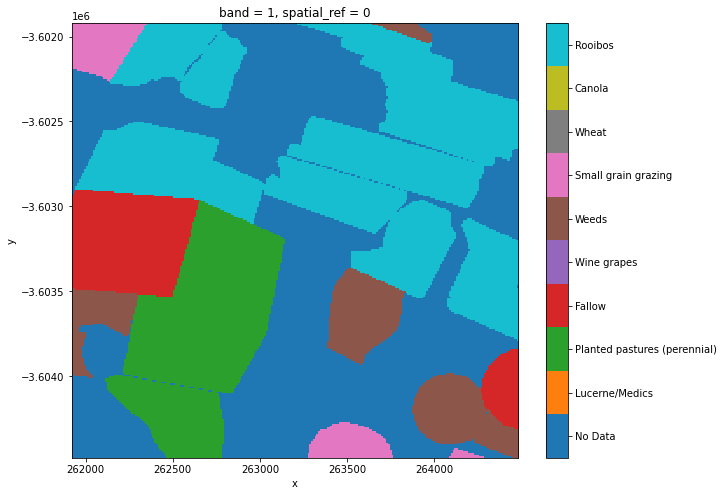

In [9]:
from pystac.extensions.label import LabelExtension
import matplotlib.pyplot as plt
import numpy as np

ext = LabelExtension.ext(label_item)
r = requests.get(label_item.assets["raster_values"].get_absolute_href())
classes = list(r.json().values())

fig, ax = plt.subplots(figsize=(10, 8))
p = labels.plot.imshow(
    ax=ax, cmap="tab10", add_colorbar=False, vmin=0, vmax=len(classes)
)
cbar = plt.colorbar(p)
cbar.set_ticks(np.arange(0.5, len(classes) + 0.5))
cbar.set_ticklabels(classes);

### Load Sentinel-2 Level 2-A Scenes

As we discovered, that item is from a specific date / time. We'll search for Sentinel-2 scenes in the Planetary Computer's catalog overlapping with our training labels around that datetime. We'll use `pystac-client` to make this easier. First, we define a client to work with the endpoint:

In [10]:
stac_client = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

### Exercise: Search for matching scenes

Use `stac_client.search` to search Planetary Computer STAC catalog for matching scenes. Find scenes taht

1. Are from the Sentinel-2 Level 2-A collection (hint: specify `collections` as a list)
2. Cover the bounding box of `label_item` (hint: specify `bbox`)
3. Are from the month before and after the datetime of `label_item` (hint: specify `datetime` as a range like `<start>/<end>`)

Then get the matching items with `search.get_all_items()`.

How many items match your search?

In [15]:
search = stac_client.search(
    collections=...,
    bbox=...,
    datetime=...,
    limit=500,  # fetch in batches of 500
)
items = search.get_all_items()
# how many items match your search?

Writing solutions/search.py


In [ ]:
%load solutions/search.py

Let's find a scene with few clouds. That information is available under the `EOExtension`.

In [12]:
from pystac.extensions.eo import EOExtension

sentinel_item = sorted(items, key=lambda item: EOExtension.ext(item).cloud_cover)[0]

And now visualize the Sentinel scene, overlaying the bounding box of the label scene.

In [13]:
sentinel_item.assets["tilejson"].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=sentinel-2-l2a&items=S2B_MSIL2A_20170728T082559_R021_T34HBK&assets=visual-10m&bidx=1,2,3&nodata=0'

In [14]:
from ipyleaflet import Map, TileLayer, GeoJSON

center = shapely.geometry.shape(label_item.geometry).centroid.bounds[:2][::-1]

m = Map(center=center, zoom=12)
layer = TileLayer(
    url=requests.get(sentinel_item.assets["tilejson"].href).json()["tiles"][0],
)
m.add_layer(layer)
m.add_layer(GeoJSON(data=label_item.geometry))
m

Map(center=[-32.54092743431243, 18.47842261141666], controls=(ZoomControl(options=['position', 'zoom_in_text',…

We have a bit of work to align the training labels and the image. First, the coordinate reference system (`epsg` code) doesn't match.

In [15]:
from pystac.extensions.projection import ProjectionExtension

print("  Labels CRS:", labels.rio.crs.to_epsg())
print("Sentinel CRS:", ProjectionExtension.ext(sentinel_item).epsg)

  Labels CRS: 32634
Sentinel CRS: 32734


We'll try to do everything in the coordinates of the labels. As we load the training data into a DataArray, we'll reproject it to the labels' CRS. We'll also trim it down to just the bit we need, covering the labels scene, to avoid using too much memory. `stackstac` handles all of this for us.

In [16]:
import planetary_computer

signed_item = planetary_computer.sign(sentinel_item)

In [17]:
import stackstac

assets = ["B02", "B03", "B04", "B05", "B06", "B07", "B09"]
data = (
    stackstac.stack(
        signed_item.to_dict(),
        assets=assets,
        epsg=labels.rio.crs.to_epsg(),  # reproject to the labels CRS
        bounds=labels.rio.bounds(),  # crop to the labels' bounds
        resolution=10,  # resample all assets to the highest resolution
        dtype="float32",
    )
    .where(lambda x: x > 0)
    .squeeze()
)  # 0 is nodata

assert data.shape[1:] == labels.shape

data = data.compute()
data

<xarray.DataArray 'stackstac-e96103e6c5db8c5087778132375b422b' (band: 7, y: 256, x: 256)>
array([[[ 589.,  573.,  533., ...,  901.,  377.,  526.],
        [ 437.,  443.,  438., ...,  857.,  643.,  520.],
        [ 379.,  410.,  434., ...,  883.,  773.,  513.],
        ...,
        [ 480.,  517.,  455., ...,  888.,  948.,  730.],
        [ 344.,  504.,  469., ...,  724.,  760.,  620.],
        [ 120.,  277.,  260., ...,  652.,  673.,  608.]],

       [[1176., 1156., 1152., ..., 1246.,  608.,  732.],
        [1110., 1084., 1106., ..., 1266.,  750.,  708.],
        [1021., 1072., 1092., ..., 1158., 1232.,  730.],
        ...,
        [ 589.,  659.,  600., ..., 1234., 1344., 1128.],
        [ 394.,  647.,  618., ..., 1294., 1256., 1042.],
        [ 182.,  325.,  353., ...,  989., 1068.,  961.]],

       [[1004.,  932.,  897., ..., 1632.,  777.,  962.],
        [ 780.,  780.,  750., ..., 1518., 1152.,  933.],
        [ 654.,  747.,  713., ..., 1568., 1404.,  965.],
        ...,
...
        ...,
        [1260., 1260., 1374., ..., 2796., 2827., 2827.],
        [ 878.,  878., 1027., ..., 2122., 2369., 2369.],
        [ 878.,  878., 1027., ..., 2122., 2369., 2369.]],

       [[4484., 4484., 4454., ..., 2034., 1784., 1784.],
        [4484., 4484., 4454., ..., 2034., 1784., 1784.],
        [4765., 4765., 4769., ..., 1880., 1963., 1963.],
        ...,
        [1315., 1315., 1397., ..., 3045., 2952., 2952.],
        [ 990.,  990., 1136., ..., 2351., 2548., 2548.],
        [ 990.,  990., 1136., ..., 2351., 2548., 2548.]],

       [[4871., 4871., 4871., ..., 1847., 1847., 1847.],
        [4871., 4871., 4871., ..., 1847., 1847., 1847.],
        [4871., 4871., 4871., ..., 1847., 1847., 1847.],
        ...,
        [1110., 1110., 1110., ..., 2466., 2466., 2466.],
        [1110., 1110., 1110., ..., 2466., 2466., 2466.],
        [1110., 1110., 1110., ..., 2466., 2466., 2466.]]], dtype=float32)
Coordinates: (12/46)
    time                                     datetime64[ns] 2017-07-28T08:25:...
    id                                       <U38 'S2B_MSIL2A_20170728T082559...
  * band                                     (band) <U3 'B02' 'B03' ... 'B09'
  * x                                        (x) float64 2.619e+05 ... 2.645e+05
  * y                                        (y) float64 -3.602e+06 ... -3.60...
    s2:mgrs_tile                             <U5 '34HBK'
    ...                                       ...
    proj:transform                           (band) object None ... [60.0, 0....
    gsd                                      (band) object None None ... 20 60
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) float64 0.49 0.56 ... 0.945
    full_width_half_max                      (band) float64 0.098 ... 0.026
    epsg                                     int64 32634
Attributes:
    spec:        RasterSpec(epsg=32634, bounds=(261920, -3604480, 264480, -36...
    crs:         epsg:32634
    transform:   | 10.00, 0.00, 261920.00|\n| 0.00,-10.00,-3601920.00|\n| 0.0...
    resolution:  10

Our shapes match (256 x 256 patch), but the labels don't quite.

In [18]:
labels.x

<xarray.DataArray 'x' (x: 256)>
array([261925., 261935., 261945., ..., 264455., 264465., 264475.])
Coordinates:
    band         int64 1
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
    spatial_ref  int64 0

In [19]:
data.x

<xarray.DataArray 'x' (x: 256)>
array([261920., 261930., 261940., ..., 264450., 264460., 264470.])
Coordinates: (12/37)
    time                                     datetime64[ns] 2017-07-28T08:25:...
    id                                       <U38 'S2B_MSIL2A_20170728T082559...
  * x                                        (x) float64 2.619e+05 ... 2.645e+05
    s2:mgrs_tile                             <U5 '34HBK'
    instruments                              <U3 'msi'
    s2:reflectance_conversion_factor         float64 0.9692
    ...                                       ...
    s2:snow_ice_percentage                   float64 0.02921
    s2:saturated_defective_pixel_percentage  float64 0.0
    s2:cloud_shadow_percentage               float64 0.008409
    s2:high_proba_clouds_percentage          float64 0.01307
    proj:bbox                                object {6500020.0, 6390220.0, 19...
    epsg                                     int64 32634

They're off by half a pixel (5 units in coordinate space). This probably just comes from one dataset labeling the center of the pixel and the other labeling the top-left corner. It'd be good to verify that. In the meantime, let's just update the labels on `data`

In [20]:
data2 = data.assign_coords(
    y=lambda ds: (ds.y - 5).round(),  # fix half-pixel label issue
    x=lambda ds: (ds.x + 5).round(),
)

Now we should be all set.

In [21]:
assert (data2.x.data == labels.x.data).all()
assert (data2.y.data == labels.y.data).all()

And we can spot-check out transformation visually. Let's plot the Red band.

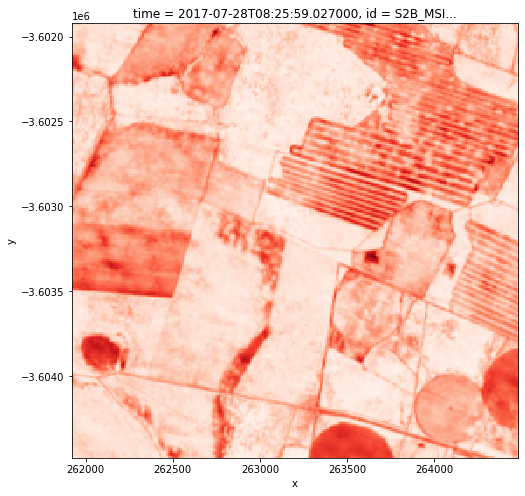

In [22]:
data2.sel(band="B04").plot.imshow(figsize=(8, 8), cmap="Reds", add_colorbar=False);

Which looks pretty close to what we want.

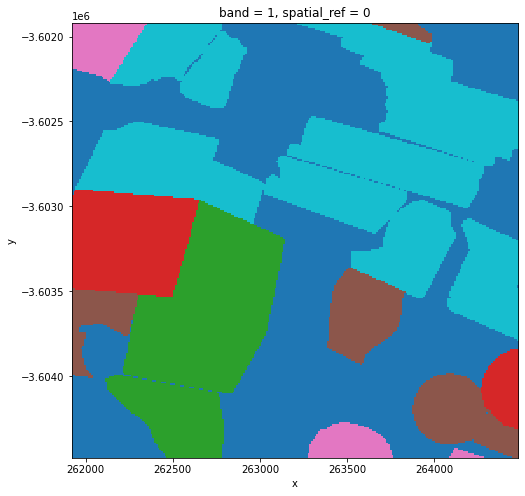

In [23]:
labels.plot.imshow(figsize=(8, 8), add_colorbar=False, cmap="tab10");

## Train a Baseline Model

We've come this far, we might as well do some machine learning! We'll use a scikit-learn KNeighborsClassfier ([User Guide](https://scikit-learn.org/stable/modules/neighbors.html#classification), [API Reference](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) to establish a baseline model for this dataset.

In [24]:
import sklearn.neighbors
import sklearn.model_selection

As usual with scikit-learn, the estimator expects an intput array of `(n_samples, n_features)`. In this case a "sample" will be a single pixel, and the feature will be all the bands. We'll get to that shape by stacking all the the pixels into one long array.

In [25]:
X = data2.stack(pixel=("y", "x")).T
X.shape

(65536, 7)

We'll also reshape the labels to be a 1-D array `(n_features,)`

In [26]:
y = labels.stack(pixel=("y", "x"))
y.shape

(65536,)

In [27]:
assert X.indexes["pixel"].equals(y.indexes["pixel"])

### Exercise: Train the model

In this exercise, we'll train the KNeighborsClassfier model on a subset of the data. We'll then score it on the remainder 
of the data.

First, split `X` and `y` into train and test parts. See [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) for help.

In [ ]:
X_train, X_test, y_train, y_test = ...

In [ ]:
# train / test split X and y
%load solutions/train_test_split.py

Now fit the model on `X_train` and `y_train`.

In [29]:
# fit the KNeighborsClassifier
clf = sklearn.neighbors.KNeighborsClassifier(random_state=0)
clf.fit(...)

KNeighborsClassifier()

In [ ]:
%load solutions/fit_knn.py

Score that model on the training data.

In [30]:
# Check the score on the training dataset
clf.score(...)

0.8953450520833334

In [ ]:
%load solutions/score_knn_test.py

We're overfitting a bit (89% on our training dataset, 84% on our test), but not too bad. Let's visualize the predictions.

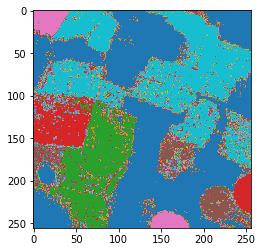

In [32]:
import rasterio.plot

yhat = clf.predict(X)

rasterio.plot.show(yhat.reshape(labels.shape), cmap="tab10");

Not *awful*, but certainly room for improvement. A few things to note:

1. We haven't done any fancy preprocessing (e.g. mosaicing scenes to remove clouds) that could improve this model.
2. We haven't done any fancy hyper-parameter tuning that could improve this model.
3. We aren't using the spatial "context" of each pixel at all, which leads to the splotchiness in our predictions. If a pixel is surrounded on all sides by Wheat pixels, then it's probably a Wheat pixel. But our current model has no idea about the neighboring pixels.
4. There's a lot of variation across the scenes in the label data. Our model hasn't seen any of those, so likely won't generalize well to them. We'd need to train on more data.